In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
import shap

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

import xgboost as xgb
from xgboost import XGBRegressor
from bayes_opt import BayesianOptimization


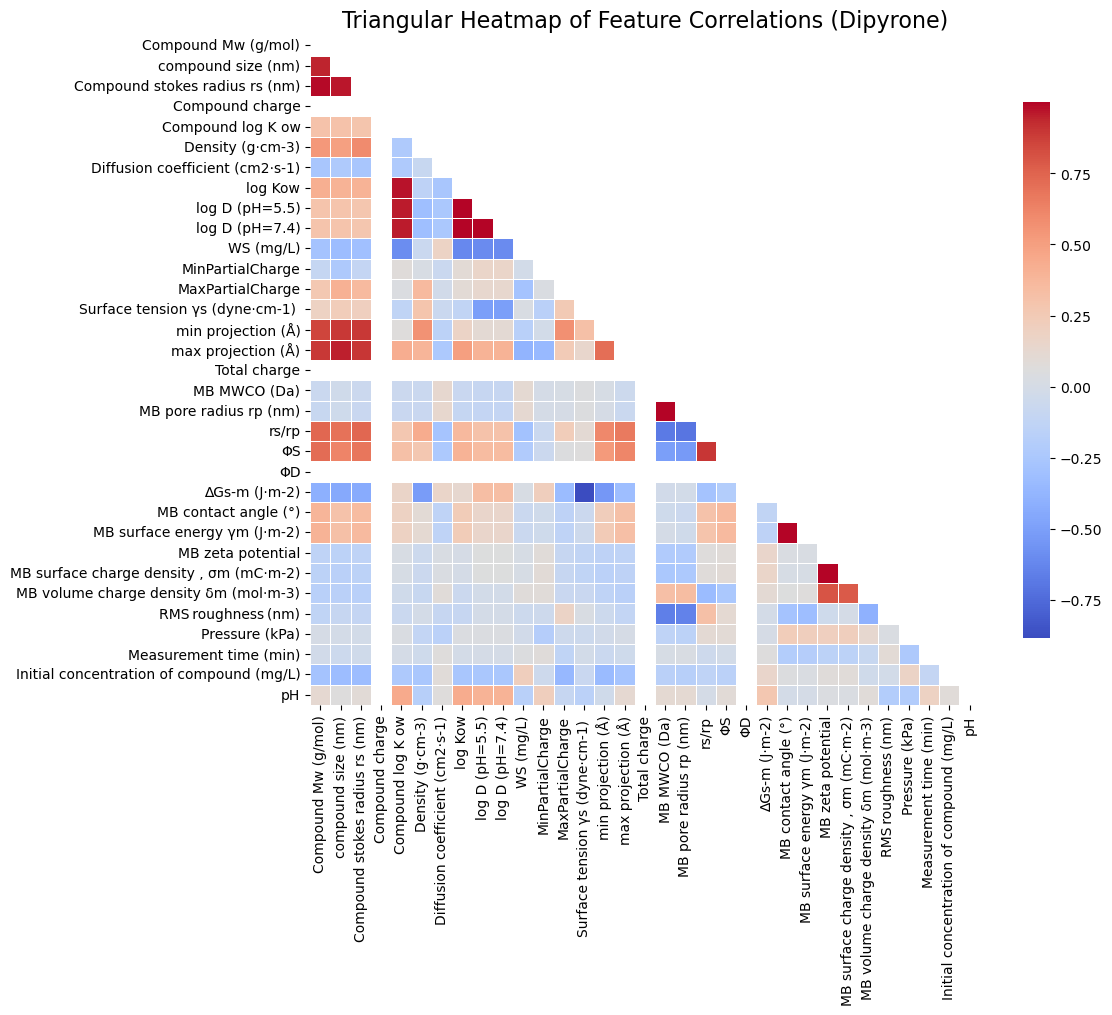

Highly correlated feature pairs (|r| > 0.7):
Compound Mw (g/mol) vs compound size (nm): r = 0.95
Compound Mw (g/mol) vs Compound stokes radius rs (nm): r = 0.99
Compound Mw (g/mol) vs min projection (Å): r = 0.86
Compound Mw (g/mol) vs max projection (Å): r = 0.89
Compound Mw (g/mol) vs rs/rp: r = 0.74
Compound Mw (g/mol) vs ΦS: r = 0.71
compound size (nm) vs Compound stokes radius rs (nm): r = 0.97
compound size (nm) vs min projection (Å): r = 0.89
compound size (nm) vs max projection (Å): r = 0.95
Compound stokes radius rs (nm) vs min projection (Å): r = 0.89
Compound stokes radius rs (nm) vs max projection (Å): r = 0.90
Compound stokes radius rs (nm) vs rs/rp: r = 0.74
Compound log K ow vs log Kow: r = 0.97
Compound log K ow vs log D (pH=5.5): r = 0.96
Compound log K ow vs log D (pH=7.4): r = 0.96
log Kow vs log D (pH=5.5): r = 0.99
log Kow vs log D (pH=7.4): r = 0.99
log D (pH=5.5) vs log D (pH=7.4): r = 1.00
Surface tension γs (dyne·cm-1)  vs ∆Gs-m (J·m-2): r = -0.88
min projectio

In [121]:
# ===== Load the dataset =====
datasets = pd.read_excel('MembraneDataset_353.xlsx')
X = datasets.iloc[:, 6:39]
y = datasets.iloc[:, 39]

# ===== Compute the feature correlation matrix =====
corr_matrix = X.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# ===== Plot triangular heatmap =====
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix, 
    mask=mask, 
    cmap='coolwarm', 
    annot=False, 
    fmt=".2f", 
    linewidths=0.5, 
    square=True, 
    cbar_kws={"shrink": .8}
)
plt.title("Triangular Heatmap of Feature Correlations (Dipyrone)", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ===== Normalize feature data =====
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# ===== Recalculate the correlation matrix after scaling =====
correlation_matrix = X_scaled.corr()

# ===== Identify highly correlated feature pairs =====
high_corr_pairs = [
    (correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j])
    for i in range(len(correlation_matrix.columns))
    for j in range(i + 1, len(correlation_matrix.columns))
    if abs(correlation_matrix.iloc[i, j]) > 0.7
]

# ===== Print highly correlated pairs =====
print("Highly correlated feature pairs (|r| > 0.7):")
for feature1, feature2, corr_value in high_corr_pairs:
    print(f"{feature1} vs {feature2}: r = {corr_value:.2f}")


In [122]:
# === Step 1: Compute the correlation matrix ===
corr_matrix = X.corr().abs()

# === Step 2: Build a strong correlation graph (|r| > 0.7 means an edge) ===
threshold = 0.7
adjacency = (corr_matrix > threshold).astype(int)
np.fill_diagonal(adjacency.values, 0)  # Remove self-loops

# === Step 3: Define protected features ===
protected = ['ΦS', '∆Gs-m (J·m-2)', 'ΦD']

# === Step 4: Count the number of strong correlations for each feature ===
high_corr_count = (corr_matrix > threshold).sum() - 1  # Exclude self-correlation

# === Step 5: Find all features connected to the protected ones using BFS ===
def get_connected_features(start_feats, adjacency_matrix):
    visited = set(start_feats)
    queue = list(start_feats)
    while queue:
        f = queue.pop(0)
        if f not in adjacency_matrix.columns:
            continue
        connected = list(adjacency_matrix.columns[adjacency_matrix.loc[f] == 1])
        for c in connected:
            if c not in visited:
                visited.add(c)
                queue.append(c)
    return visited

connected_to_protected = get_connected_features(protected, adjacency)

# === Step 6: Define removal rules ===
# 1. In highly correlated pairs, remove redundant features (keep protected ones)
# 2. Remove all non-protected features that are connected to protected ones
to_drop = set()

for col in corr_matrix.columns:
    for row in corr_matrix.index:
        if row == col:
            continue
        corr_value = corr_matrix.loc[row, col]
        if corr_value > threshold:
            # If one is protected, keep it and drop the other
            if row in protected and col not in protected:
                to_drop.add(col)
            elif col in protected and row not in protected:
                to_drop.add(row)
            # Otherwise, drop the one correlated with more features
            elif row not in protected and col not in protected:
                if high_corr_count[row] > high_corr_count[col]:
                    to_drop.add(row)
                elif high_corr_count[row] < high_corr_count[col]:
                    to_drop.add(col)
                else:
                    to_drop.add(sorted([row, col])[1])

# === Step 7: Recursively remove features indirectly connected to protected ones ===
for feat in connected_to_protected:
    if feat not in protected:
        to_drop.add(feat)

# === Step 8: Remove redundant features ===
df_reduced = df.drop(columns=list(to_drop), errors='ignore')

# === Step 9: Output summary ===
print("Removed features:", sorted(to_drop))
print("Remaining feature count:", df_reduced.shape[1])

# === Step 10: Save the result ===
df_reduced.to_excel("MembraneDataset_reduced_auto.xlsx", index=False)

Removed features: ['Compound Mw (g/mol)', 'Compound stokes radius rs (nm)', 'MB MWCO (Da)', 'MB pore radius rp (nm)', 'MB surface energy γm (J·m-2)', 'MB volume charge density δm (mol·m-3)', 'MB zeta potential', 'Surface tension γs (dyne·cm-1) ', 'compound size (nm)', 'log D (pH=5.5)', 'log D (pH=7.4)', 'log Kow', 'max projection (Å)', 'min projection (Å)', 'rs/rp']
Remaining feature count: 18


In [135]:
import pandas as pd
from rdkit import Chem
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import metrics

# ===== Load dataset and substructures =====
datasets = pd.read_excel('ML-improve.xlsx')
substructure = pd.read_csv('match.txt', header=None)

# Extract molecular descriptor columns
concatenated = pd.concat([datasets.iloc[:, 7:25]], axis=1)
arr3 = concatenated.to_numpy()

# ===== Match all SMILES with substructures (count occurrences) =====
arr1 = [[0 for _ in range(len(substructure))] for _ in range(len(datasets))]
smiles_list = datasets.SMILES

for i, smi in enumerate(smiles_list):
    mol = Chem.MolFromSmiles(smi)
    for j, sub in enumerate(substructure[0].values):
        subMol = Chem.MolFromSmarts(sub)
        matches = mol.GetSubstructMatches(subMol)
        if len(matches):
            arr1[i][j] = len(matches)

# Combine substructure counts with other features
arr = np.hstack((arr1, arr3))

X = arr
y = datasets.iloc[:, 25]

# ===== Split data into training and testing sets =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=70
)

# ===== Initialize and tune XGBoost model =====
model = xgb.XGBRegressor()

# Define parameter grid
param_grid = {
    'colsample_bytree': [0.68],
    'learning_rate': [0.25],
    'max_depth': [5],
    'alpha': [30],
    'n_estimators': [200]
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    model,
    param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# ===== Display best parameters and model performance =====
print("Best parameters found:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('Training R²:', metrics.r2_score(y_train, y_train_pred))
print('Testing R²:', metrics.r2_score(y_test, y_test_pred))

Best parameters found: {'alpha': 30, 'colsample_bytree': 0.68, 'learning_rate': 0.25, 'max_depth': 5, 'n_estimators': 200}
Training R²: 0.9788887528831612
Testing R²: 0.8762213804269879


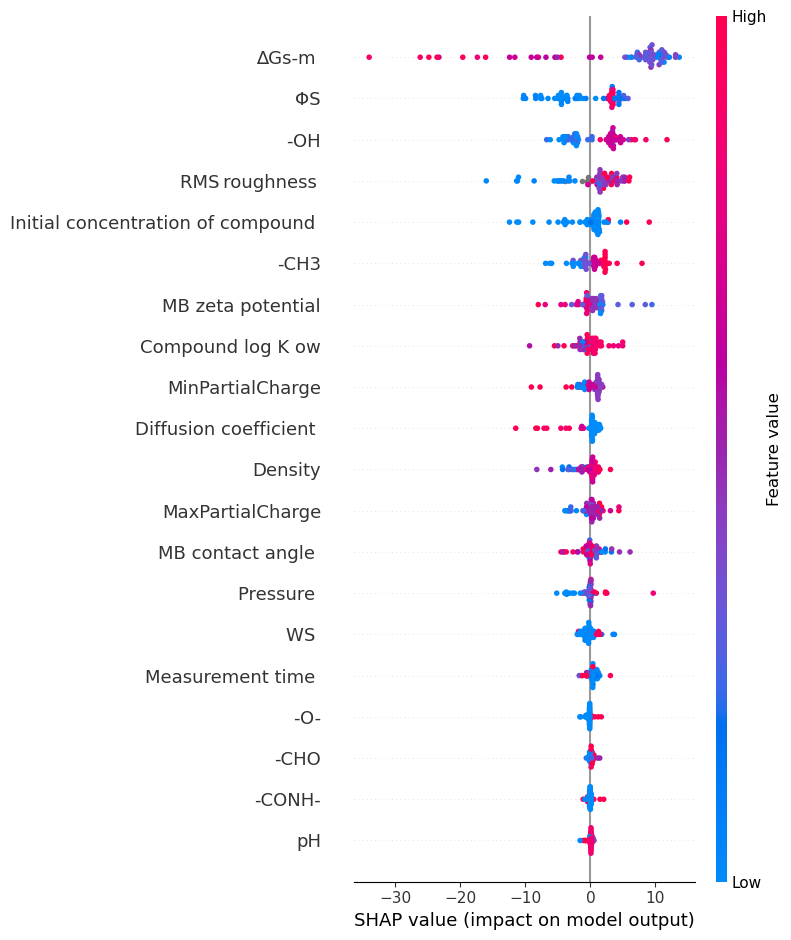

In [114]:
import shap

# ===== Initialize SHAP explainer using the best model =====
explainer = shap.TreeExplainer(best_model)

# ===== Compute SHAP values =====
shap_values = explainer.shap_values(X_test)

# ===== Define feature names =====
# Substructure names (manually labeled)
substructure_names = ['-CH3', '-OH', '-CHO', 'C=O', 'Benzene Ring',
                      '-CONH-', '-O-', '-F', '-Cl', '-COO-', '-COOH', '-NH2']

# Add the original molecular descriptor column names
feature_names = substructure_names + concatenated.columns.tolist()

# ===== Generate SHAP summary plot =====
shap.summary_plot(
    shap_values, 
    X_test, 
    feature_names=feature_names, 
    max_display=20
)


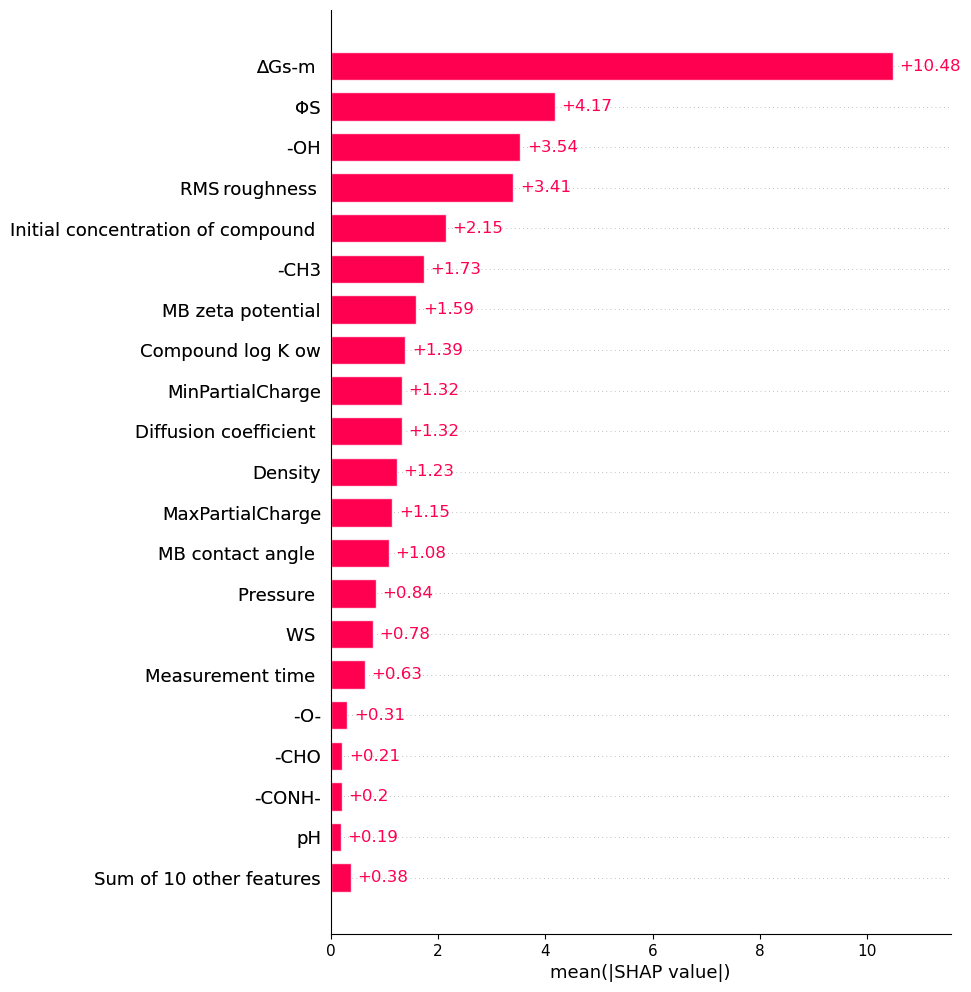

In [115]:
import shap

# ===== Initialize SHAP explainer using the trained model =====
explainer = shap.TreeExplainer(best_model)

# ===== Compute SHAP values for the test set =====
shap_values = explainer.shap_values(X_test)

# ===== Create a SHAP Explanation object =====
# (Optional, for compatibility with shap.plots.bar)
shap_explainer = shap.Explanation(
    values=shap_values,
    feature_names=feature_names
)

# ===== Plot SHAP feature importance (bar chart) =====
shap.plots.bar(shap_explainer, max_display=21)


In [116]:
# ===== Calculate MAE and RMSE for the training set =====
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# ===== Calculate MAE and RMSE for the test set =====
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# ===== Print the results =====
print('Training MAE:', train_mae)
print('Training RMSE:', train_rmse)
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)


训练 MAE: 2.556439492455611
训练 RMSE: 4.277368553411762
测试 MAE: 7.325487713343661
测试 RMSE: 12.805356334258954


In [117]:
# ===== Export only the true and predicted target values (no features) =====
train_results = pd.DataFrame({
    "y_true": y_train.values,
    "y_pred": y_train_pred
})

test_results = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": y_test_pred
})

# ===== Save both DataFrames to separate sheets in one Excel file =====
with pd.ExcelWriter("xgboost.xlsx") as writer:
    train_results.to_excel(writer, sheet_name="Train", index=False)
    test_results.to_excel(writer, sheet_name="Test", index=False)


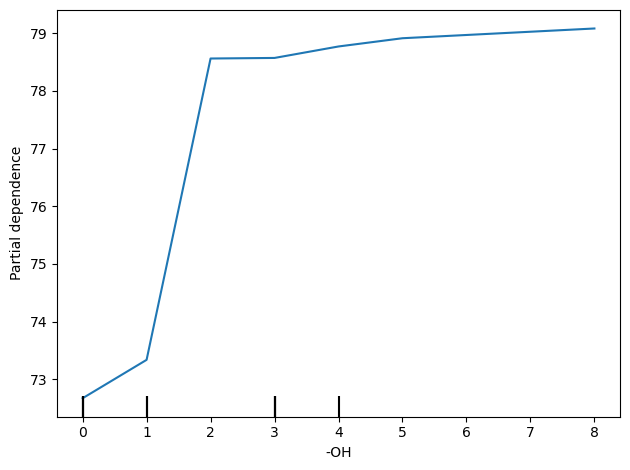

In [136]:
# ===== Ensure X_train is a DataFrame with column names =====
if not isinstance(X_train, pd.DataFrame):
    X_train = pd.DataFrame(X_train, columns=feature_names)

feature_name = "-OH"

# ===== Check if the feature exists =====
if feature_name not in X_train.columns:
    raise ValueError(f"The feature '{feature_name}' is not present in the DataFrame columns.")

# ===== Create Partial Dependence Plot (PDP) =====
disp = PartialDependenceDisplay.from_estimator(
    estimator=best_model,
    X=X_train,
    features=[feature_name],
    kind="average"
)

# ===== Extract data from the PDP for saving =====
line = disp.lines_[0][0]  # lines_ is nested: first index = feature, second = plot element
x_vals = line.get_xdata()
y_vals = line.get_ydata()

# ===== Construct DataFrame with PDP values =====
pdp_single_df = pd.DataFrame({
    f"{feature_name.strip()}": x_vals,
    "Partial Dependence": y_vals
})

# ===== Export PDP data to Excel =====
output_filename = "pdp-OH.xlsx"
pdp_single_df.to_excel(output_filename, index=False)

# ===== Show the PDP figure =====
plt.tight_layout()
plt.show()

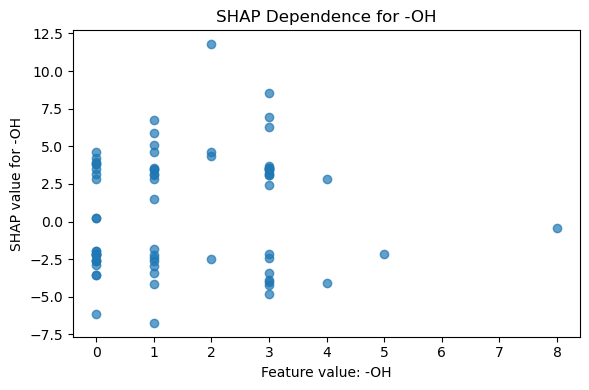

In [128]:
# ===== Assume feature_names, shap_values, X_train are already defined =====
target_feature = "-OH"

# ===== 1️⃣ Find the index of the target feature =====
if target_feature not in feature_names:
    raise ValueError(f"{target_feature} is not in feature_names!")
feature_index = feature_names.index(target_feature)

# ===== 2️⃣ Extract the feature values =====
if isinstance(X_train, pd.DataFrame):
    feature_vals = X_train.iloc[:, feature_index].values
elif isinstance(X_train, np.ndarray):
    feature_vals = X_train[:, feature_index]
else:
    raise TypeError("X_train must be a DataFrame or ndarray")

# ===== 3️⃣ Extract SHAP values for the target feature =====
shap_vals = shap_values[:, feature_index]

# ===== 4️⃣ Align lengths to avoid mismatch =====
min_len = min(len(feature_vals), len(shap_vals))
feature_vals = feature_vals[:min_len]
shap_vals = shap_vals[:min_len]

# ===== 5️⃣ Plot SHAP dependence scatter plot =====
plt.figure(figsize=(6, 4))
plt.scatter(feature_vals, shap_vals, alpha=0.7)
plt.xlabel(f"Feature value: {target_feature}")
plt.ylabel(f"SHAP value for {target_feature}")
plt.title(f"SHAP Dependence for {target_feature}")
plt.tight_layout()
plt.show()

# ===== 6️⃣ Build DataFrame and export to Excel =====
df_export = pd.DataFrame({
    f"feature_value({target_feature})": feature_vals,
    f"shap_value({target_feature})": shap_vals
})

output_filename = f"shap-{target_feature}.xlsx"
df_export.to_excel(output_filename, index=False)


✅ Data successfully exported to 'bivariate_pdp_data.xlsx'


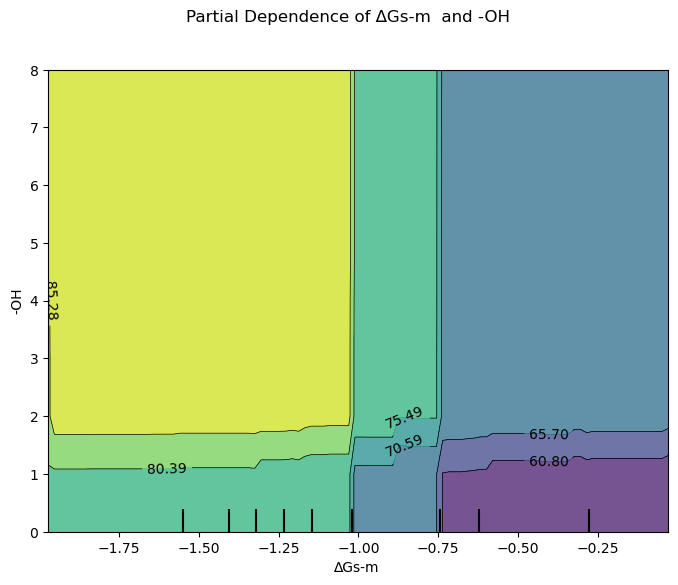

In [133]:
# Define feature pair
features = ["∆Gs-m ", "-OH"]

# Compute two-way Partial Dependence
pdp_double = partial_dependence(best_model, X_train, features)

# grid_values is a list containing the values for each feature
x_vals = pdp_double["grid_values"][0]
y_vals = pdp_double["grid_values"][1]

# average is a 2D array corresponding to the x-y grid
z_vals = pdp_double["average"][0]

# Create a DataFrame to store PDP data
pdp_double_df = pd.DataFrame({
    "∆Gs-m ": np.repeat(x_vals, len(y_vals)),
    "-OH": np.tile(y_vals, len(x_vals)),
    "Partial Dependence": z_vals.flatten()
})

# Export data
pdp_double_df.to_excel("bivariate_pdp_data.xlsx", index=False)
print("✅ Data successfully exported to 'bivariate_pdp_data.xlsx'")

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(best_model, X_train, [features], ax=ax)
plt.suptitle(f"Partial Dependence of {features[0]} and {features[1]}")
plt.show()
